# Sobol Analysis on timeseries

Sobol analysis is commonly applied to assess the sensitivity of model outputs to input parameters. While Sobol analysis is traditionally performed on scalar outputs, it is also possible to adapt it for time series outputs.

To apply Sobol analysis to a time series object, you would need to define a specific metric or summary statistic that represents the behavior of the time series as a single value. This could be, for example, the mean, standard deviation, or maximum value of the time series.

By applying Sobol analysis to this derived metric or summary statistic, you can assess the sensitivity of the time series output to the input parameters. This would involve running the Sobol analysis on multiple instances of the time series, each corresponding to different combinations of input parameters, and analyzing the resulting sensitivity indices.

It's important to note that the interpretation of Sobol indices for time series outputs may be different from scalar outputs. The sensitivity indices would provide insights into how changes in input parameters affect the overall behavior or characteristics of the time series rather than specific time points.

In summary, while Sobol analysis is typically applied to scalar outputs, it is possible to adapt it for time series outputs by defining an appropriate summary statistic or metric and conducting the analysis on multiple instances of the time series.

From this results the following workflow
1. Define uncertainty space better.
2. Initiate the model with a sobol.sampler
3. Define statistical metrix: What outcomes are we interested? Two things coming to my mind: First what uncertaitny parameters shape the peaks in the North_degrowth scenario
4. Even more interesting: look at the global NAS and evaluate what uncertainty parameters shape the minimum of a time series -> The NAS absolute seems easier to interpret

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns




from SALib.analyze import sobol

from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers
)


from ema_workbench.em_framework.salib_samplers import get_SALib_problem

In [5]:
from ema_workbench import Model, RealParameter, TimeSeriesOutcome
from ship_model import ship_model

#What are you studying?
study='NAS_abs'

model = Model('Ships', function=ship_model)

model.time_horizon = 2100-2023+1

model.uncertainties = [RealParameter('DWT_err', 0.8, 1.2),
                       RealParameter('lifetime_err', 0.8, 1.2),
                        RealParameter('mat_err', .8, 1.2),
                       RealParameter('GDP_err', 0.8, 1.2),
                       RealParameter('rate_err', .5, 1.5),
                       RealParameter('degr_rate_err', .5, 1.5)]
#DWT_err=1,lifetime_err=1, mat_err=1, GDP_err=1, rate_err=1, degr_rate_err=1

model.outcomes = [TimeSeriesOutcome('south_SSP1-26_north_SSP1-26'), TimeSeriesOutcome('south_SSP1-26_north_SSP2-26'),
       TimeSeriesOutcome('south_SSP1-26_north_degrowth'), TimeSeriesOutcome('south_SSP2-26_north_SSP1-26'),
       TimeSeriesOutcome('south_SSP2-26_north_SSP2-26'), TimeSeriesOutcome('south_SSP2-26_north_degrowth'),
       TimeSeriesOutcome('south_degrowth_north_SSP1-26'), TimeSeriesOutcome('south_degrowth_north_SSP2-26'),
       TimeSeriesOutcome('south_degrowth_north_degrowth')]



Idea: Take for every experiment the the time where min/max NAS_abs is estabished. the mean also makes sense. lets start with it.

NOTE: If you perform this experiments again the results may differ from the graphs in the poster because the findings are not deterministic. If you want to replicate the exact results please read in the safed files.



In [6]:
from ema_workbench import ema_logging, save_results

ema_logging.log_to_stderr(ema_logging.INFO)


n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, uncertainty_sampling=Samplers.SOBOL)

save_results(results, 'Final_Assignment/data_output/NAS_abs_SOBOL.tar.gz')

[MainProcess/INFO] pool started with 8 workers
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 14000 scenarios * 1 policies * 1 model(s) = 14000 experiments
100%|██████████████████████████████████| 14000/14000 [2:35:26<00:00,  1.50it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\admin\\Documents\\GitHub\\test-repo\\MFA2\\Final_Assignment\\Final_Assignment\\data_output\\NAS_abs_SOBOL.tar.gz'

In [7]:
save_results(results, 'NAS_abs_SOBOL.tar.gz')

C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ema_workbench\em_framework\outcomes.py:539: UserWarning: still to be tested!!
  warnings.warn("still to be tested!!")
[MainProcess/INFO] results saved successfully to C:\Users\admin\Documents\GitHub\test-repo\MFA2\Final_Assignment\NAS_abs_SOBOL.tar.gz


In [8]:
experiments, outcomes =results




The first statistical metrix we study is the MEAN. Therefore we calculate for every experiment the mean and save it in a dict for the variouse outcomes.



In [26]:


def get_outcome_names(model):
    outcome_names =[]

    for outcome in model.outcomes:
        outcome_names.append(outcome.name)

    return outcome_names

def get_shapes_outcomes(outcomes):
    interm =[]
    for k, v in outcomes.items():

        interm.append((k,v.shape))

    return interm

## Study the mean

In [27]:
outcomes_mean ={(outcome): pd.DataFrame(outcomes[outcome]).mean(axis=1) for outcome in get_outcome_names(model)}


print(get_shapes_outcomes(outcomes_mean))

[('south_SSP1-26_north_SSP1-26', (14000,)), ('south_SSP1-26_north_SSP2-26', (14000,)), ('south_SSP1-26_north_degrowth', (14000,)), ('south_SSP2-26_north_SSP1-26', (14000,)), ('south_SSP2-26_north_SSP2-26', (14000,)), ('south_SSP2-26_north_degrowth', (14000,)), ('south_degrowth_north_SSP1-26', (14000,)), ('south_degrowth_north_SSP2-26', (14000,)), ('south_degrowth_north_degrowth', (14000,))]


The qustion we want to answer: How does variability in the incomes affect the median NAS abs over the whole time intervall

In [36]:
print(np.array(outcomes_mean['south_SSP1-26_north_SSP1-26']))

[ 56.58381269  54.4494876   56.58381269 ...  75.86795034 141.99029974
  67.19750072]


In [37]:
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

problem = get_SALib_problem(model.uncertainties)

results_Si =dict()

for item in get_outcome_names(model):
    results_Si[item] = sobol.analyze(problem, np.array(outcomes_mean[item]), calc_second_order=True, print_to_console=True, parallel=True)

                         ST       ST_conf
DWT_err        5.474379e-02  7.305502e-03
GDP_err        1.512916e-31  2.048101e-32
degr_rate_err  0.000000e+00  0.000000e+00
lifetime_err   5.380927e-02  6.184105e-03
mat_err        6.991225e-02  8.230257e-03
rate_err       8.638103e-01  6.773335e-02
                         S1       S1_conf
DWT_err        4.866244e-02  1.912384e-02
GDP_err       -1.673160e-17  3.439180e-17
degr_rate_err  0.000000e+00  0.000000e+00
lifetime_err   4.172645e-02  1.916365e-02
mat_err        5.602166e-02  2.611795e-02
rate_err       8.391848e-01  6.920594e-02
                                         S2       S2_conf
(DWT_err, GDP_err)            -7.446240e-03  2.910758e-02
(DWT_err, degr_rate_err)      -7.446240e-03  2.910758e-02
(DWT_err, lifetime_err)       -7.219418e-03  2.963854e-02
(DWT_err, mat_err)            -8.158867e-03  3.015579e-02
(DWT_err, rate_err)            4.483931e-04  4.189983e-02
(GDP_err, degr_rate_err)       1.563900e-17  5.586699e-17
(GDP_e

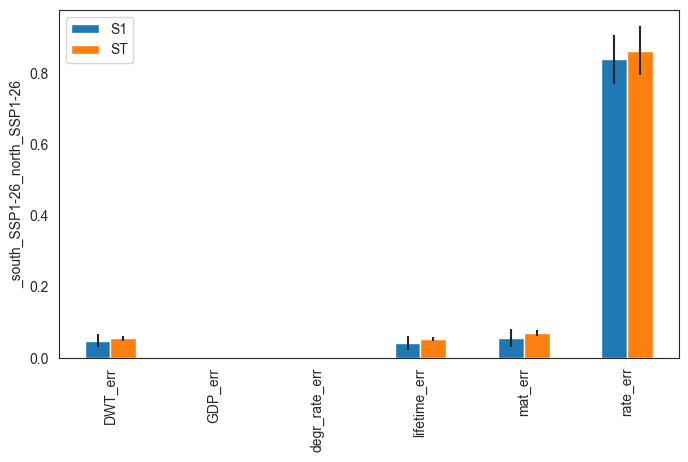

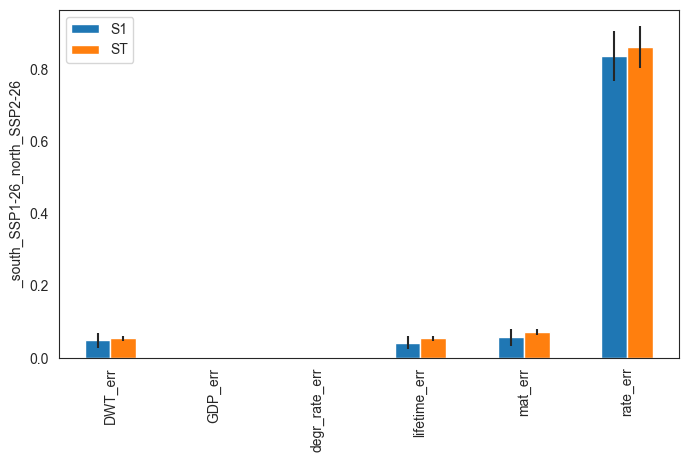

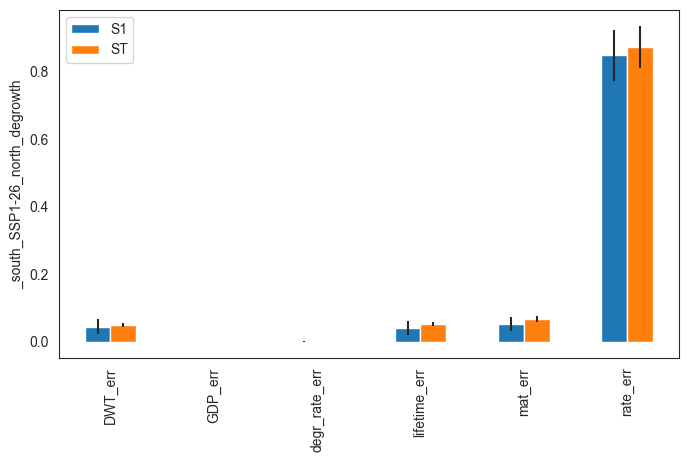

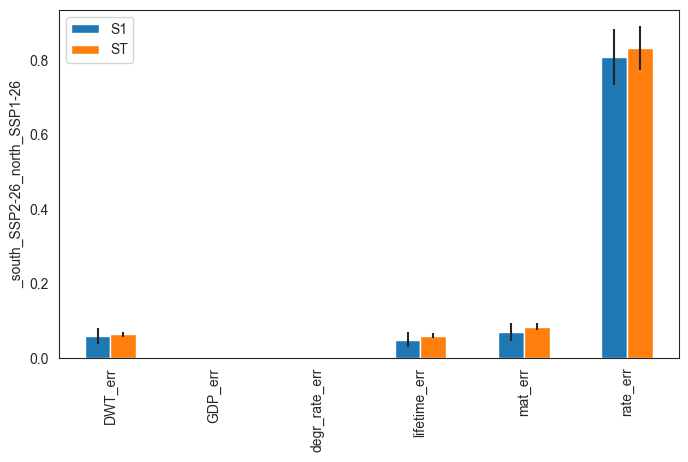

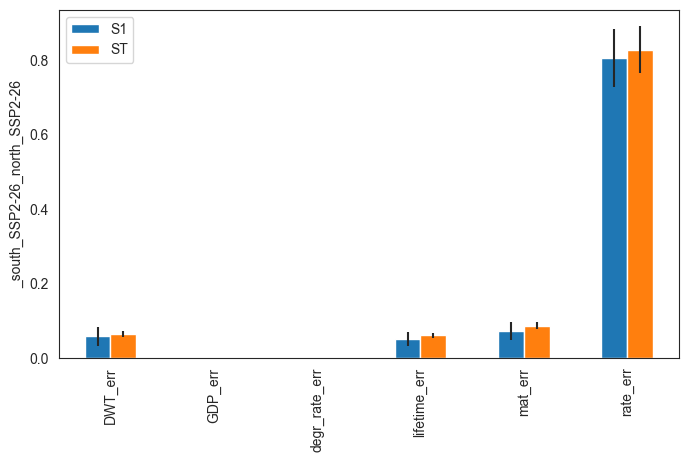

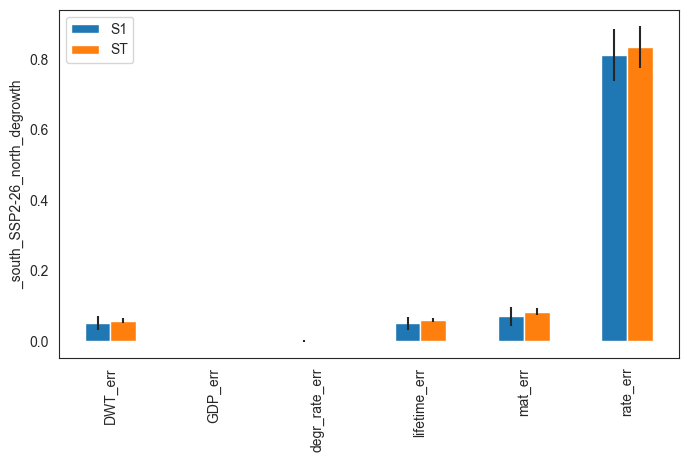

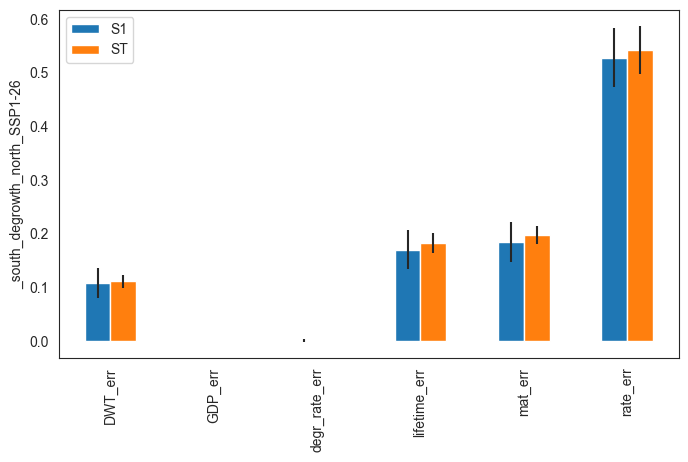

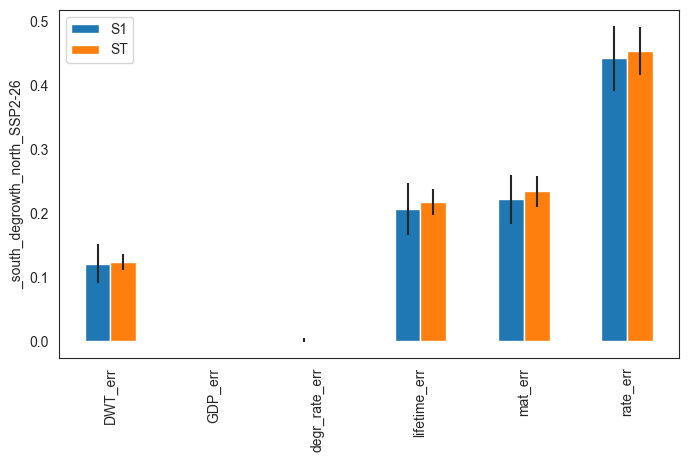

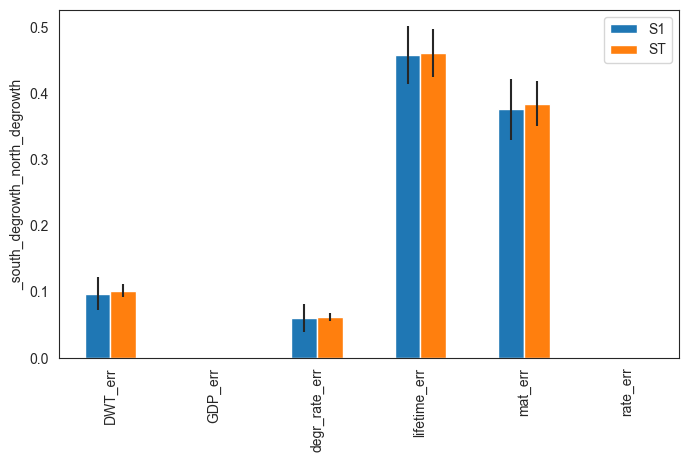

In [53]:

def plot_sobol_results_plot(model, results_Si, name=''):
    Si_filter=dict()

    for item in get_outcome_names(model):
        Si_filter[item] = {k:results_Si[item][k] for k in ['ST','ST_conf','S1','S1_conf']}
        Si_df = pd.DataFrame(Si_filter[item], index=problem['names'])

        sns.set_style('white')
        fig, ax = plt.subplots(1)

        indices = Si_df[['S1','ST']]
        err = Si_df[['S1_conf','ST_conf']]

        indices.plot.bar(yerr=err.values.T,ax=ax)
        fig.set_size_inches(8,6)
        sns.set_style(style='white')
        fig.subplots_adjust(bottom=0.3)
        plt.savefig(f"S1_ST_{name}_{item}")
        plt.ylabel(f"{name}_{item}")
        plt.show()


plot_sobol_results_plot(model, results_Si)


### Conclusions to draw from the mean analysis:
1. For most of the scenario combinations rate_err is the decisive uncertainty parameter that influences the outcome variability.
2. the scenario combinations of degrowth in the south show a lower importance of rate_err for system behaviour than the other combinations.
3. it is trivial that the rate_err is for the cases where both aggregates degrow equals zero. However the shift to the degr_rate_err is only minor and the importance of the uncertainty parameter lifetime_err and mat_err is vay higher.

## Study the max


In [46]:
outcomes_max ={(outcome): pd.DataFrame(outcomes[outcome]).max(axis=1) for outcome in get_outcome_names(model)}

results_Si_max =dict()

for item in get_outcome_names(model):
    results_Si_max[item] = sobol.analyze(problem, np.array(outcomes_max[item]), calc_second_order=True, print_to_console=True, parallel=True)



                         ST       ST_conf
DWT_err        1.072287e-01  1.189951e-02
GDP_err        1.983625e-29  3.807648e-30
degr_rate_err  0.000000e+00  0.000000e+00
lifetime_err   8.735530e-02  1.216621e-02
mat_err        1.545697e-01  1.600145e-02
rate_err       7.148172e-01  6.760530e-02
                         S1       S1_conf
DWT_err        1.000523e-01  2.810090e-02
GDP_err        1.652648e-16  3.736039e-16
degr_rate_err  0.000000e+00  0.000000e+00
lifetime_err   5.838859e-02  2.480827e-02
mat_err        1.419022e-01  2.813178e-02
rate_err       6.800820e-01  8.092584e-02
                                         S2       S2_conf
(DWT_err, GDP_err)            -1.147531e-02  4.291699e-02
(DWT_err, degr_rate_err)      -1.147531e-02  4.291699e-02
(DWT_err, lifetime_err)       -1.090247e-02  4.410813e-02
(DWT_err, mat_err)            -1.282855e-02  4.481482e-02
(DWT_err, rate_err)           -1.152157e-03  6.430139e-02
(GDP_err, degr_rate_err)      -2.613908e-17  5.611992e-16
(GDP_e

NameError: name 'plot_sobol_results_plot' is not defined

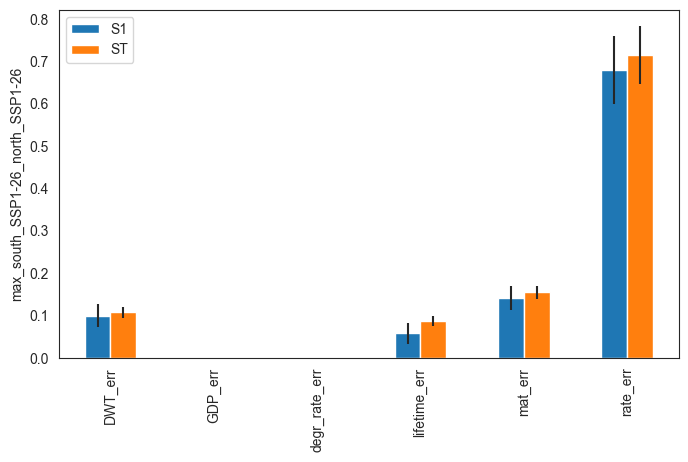

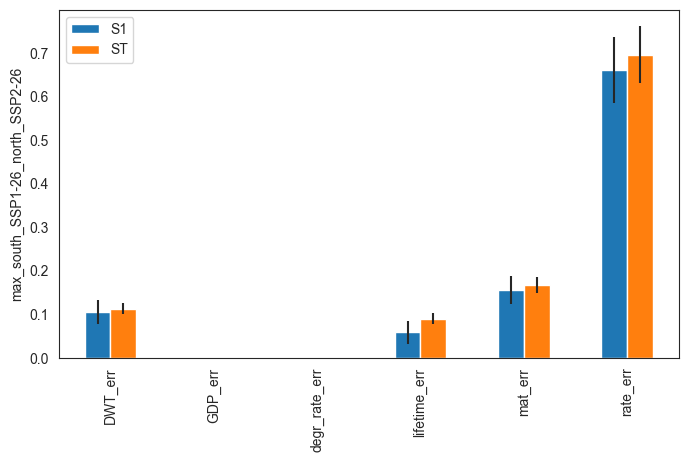

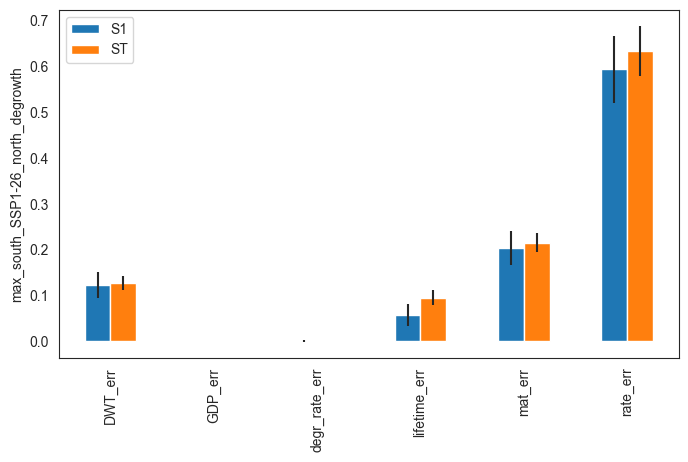

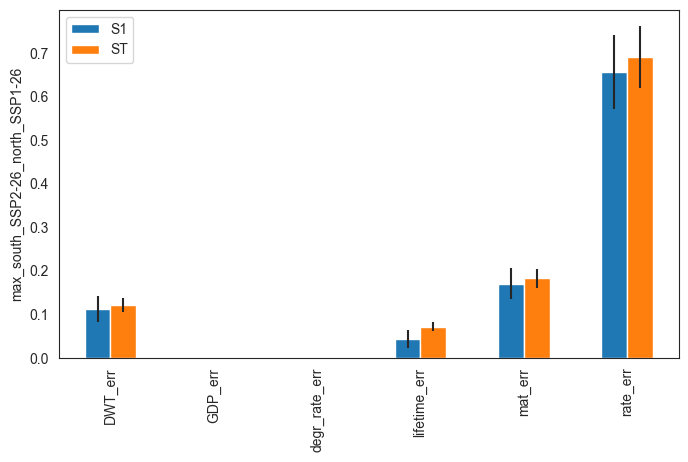

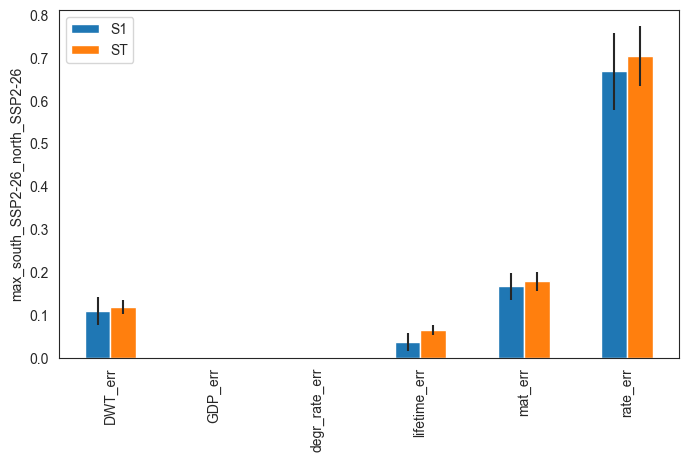

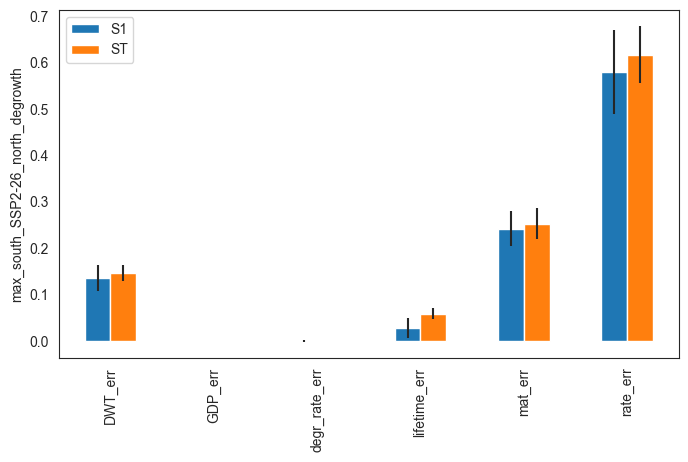

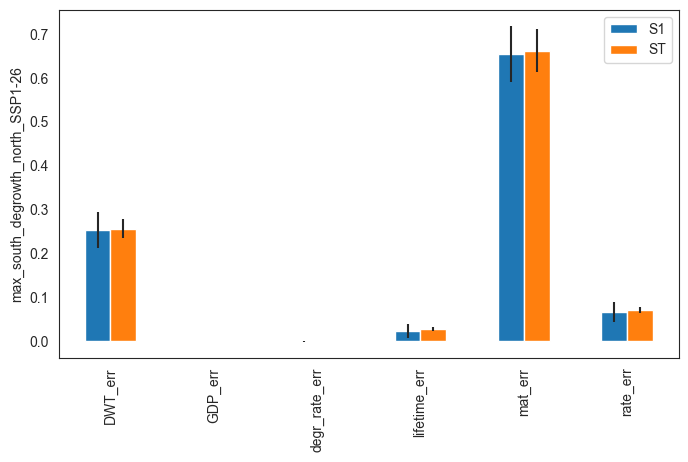

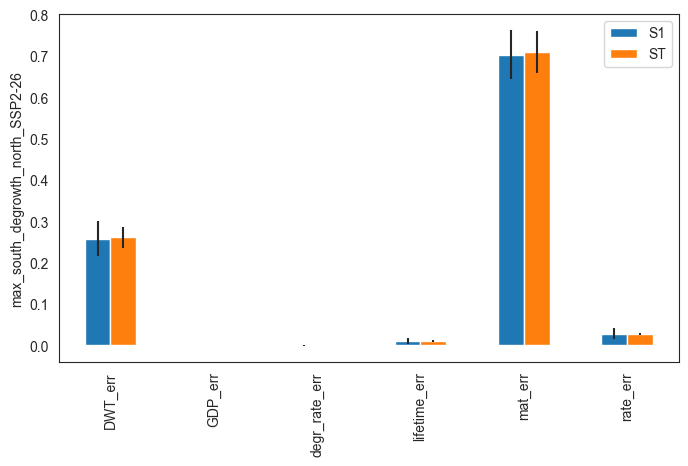

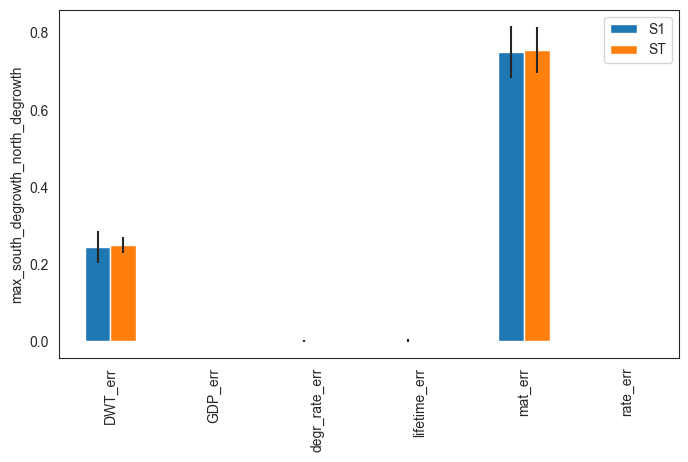

In [54]:
plot_sobol_results_plot(model, results_Si_max, name='max')

Here a view interesting things happen:

1. For scenario combinations where degrowth is not involved the rate_err is the most decisive parameter.
2. For scenarios with degrowth in the north the NAS_abs the importance of the rate_err parameter is dampened compared to the mean by about .1. Therefore it is to conclude that the a degroth trajectory in the north will most likely decrease the observable maxiumum NAS_abs for the timesireies.
3. The combinations where south follows a degrowth part show that here for the outcome the most decisive uncertain parameter is mat_err and therefore one of the technological components of the analysis. It is further suprising that the degr_rate_err seems to have a neglectable influence on the output variability.
4.